In [502]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [503]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.metrics import classification_report
import pandas as pd 

In [504]:
import ncut_loss
import build_Unet
import build_Wnet
import getData


In [505]:
from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

# DATASETS

In [506]:
path ='/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea'
parts_ds= []
dam_ds =[]
for d in os.listdir(path):
  
    if 'parts' in d:
        if "gs" in d:
            parts_ds.append(d)
    elif 'damages' in d:
        if "gs" in d:
            dam_ds.append(d)
        
path_damaged = [path+'/'+dam_ds[0],path+'/'+dam_ds[1]]

path_non_damaged = [path+'/'+parts_ds[0]]


print(path_damaged)


#path_non_damaged = '/home/ubuntu/shared/data/meta/annotations/gold_standard/2021-06/parts_2021-06_val.json'
to_keep = ["bumper_back","bumper_front","door_back_left","door_back_right","door_front_left",    
"door_front_right","fender_back_left","fender_back_right","fender_front_left","fender_front_right"] 

#to_keep='all'

['/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/gs_40004_damages.json', '/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/gs_50005_damages.json']


In [507]:
path_damaged

['/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/gs_40004_damages.json',
 '/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/gs_50005_damages.json']

In [508]:
path_non_damaged

['/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/gs_90009_parts.json']

In [509]:
dam_gen = get_damaged_generator(path_damaged, batch_size=1, dim=(128,128), to_keep=to_keep,area_threshold=5000)

Importing from COCO JSON:  27%|##6       | 1855/6968 [00:01<00:02, 1854.90it/s]

Importing from COCO JSON:  11%|#1        | 633/5610 [00:01<00:10, 456.71it/s]

In [510]:
non_dam_gen = get_non_damaged_generator(path_non_damaged, batch_size=1, dim=(128,128), to_keep=to_keep,area_threshold=5000)

Importing from COCO JSON:  11%|#1        | 1097/9928 [00:01<00:08, 1096.94it/s]

In [517]:
print(len(dam_gen.map_id))
print(len(non_dam_gen.map_id))

4033
22405


-1.0

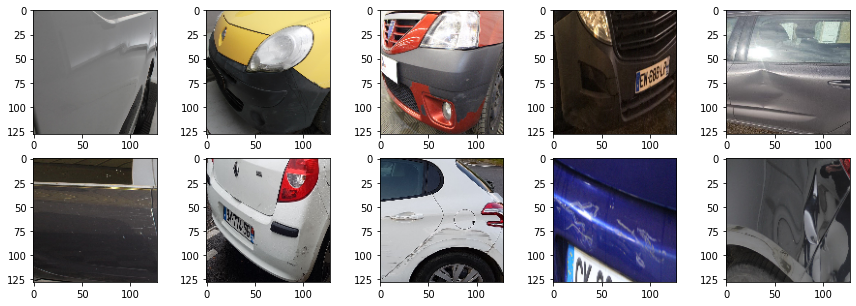

In [520]:
#dam = dam_gen.__getitem__(np.random.randint(1,1000))
#print(dam.shape)
#plt.figure(figsize=(15,15))
#plt.imshow(dam[0])

plt.figure(figsize=(15,5))
for i in range(10):
    ndam = dam_gen.__getitem__(np.random.randint(1,1000))
    ndam_ = (ndam+1)/2
    plt.subplot(2,5,i+1)
    plt.imshow(ndam_[0])

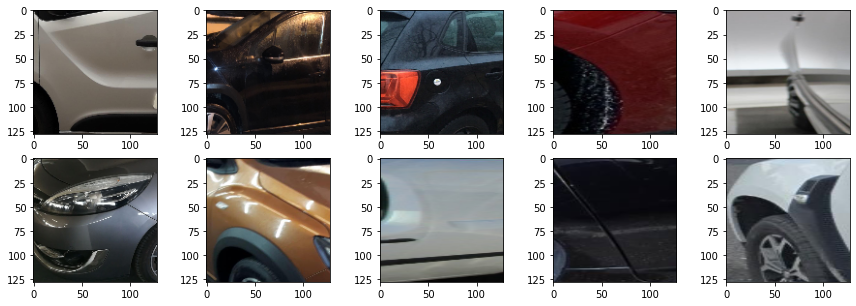

In [521]:
#ndam = non_dam_gen.__getitem__(np.random.randint(1,1000))
#print(ndam.shape)
#plt.figure(figsize=(5,5))
#plt.imshow(ndam[0])
plt.figure(figsize=(15,5))
for i in range(10):
    ndam = non_dam_gen.__getitem__(np.random.randint(1,1000))
    plt.subplot(2,5,i+1)
    ndam_ = (ndam+1)/2
    plt.imshow(ndam_[0])

In [522]:
len(dam_gen.map_id)

4033

# MODEL

In [523]:
neighbor_filter=ncut_loss.neighbor_filter((128,128))

In [524]:
encoder = build_Unet.Unet(K=18,type='encoder',input_size=128,do_dropout=True)


In [345]:
#encoder = build_Unet.build_Unet(K=18,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
#decoder = build_Unet.build_Unet(K=18,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)

encoder = build_Unet.Unet(K=18,type='encoder',input_size=128,do_dropout=True)
decoder = build_Unet.Unet(K=18,type='decoder',input_size=128,do_dropout=True)

    


wn = build_Wnet.Wnet(encoder,decoder,(128,128))

def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)


In [525]:
wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDropout/ckpt1300")

In [526]:
def rescale(image):
    return( np.array(((image+1)/2)*255 ).astype("uint8") )

In [574]:
def visualise_seg(image,encoder):
   
   
    image = tf.expand_dims(image, 0)
    
    seg = encoder(image)
    ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)
    print(np.unique(np.array(ag)))
   

    loss = ncut_loss.compute_soft_ncuts(image,seg,neighbor_filter)
    
    
    loss_r = tf.keras.losses.MeanSquaredError()(image,wn(image))
    
    plt.figure(figsize=(15,15))
    res = wn(image).numpy()[0]
    res = rescale(res)
    
    image=rescale(image)

    plt.subplot(1,3,1)
    plt.imshow(image[0])
    plt.subplot(1,3,2)
    plt.imshow(ag[0])
    plt.subplot(1,3,3)
    plt.imshow(res)
    
    return(ag)

In [575]:
wn.encoder.do_dropout=False
wn.decoder.do_dropout=False

In [576]:
wn.encoder.do_dropout

False

[ 1  2  4  8  9 16]


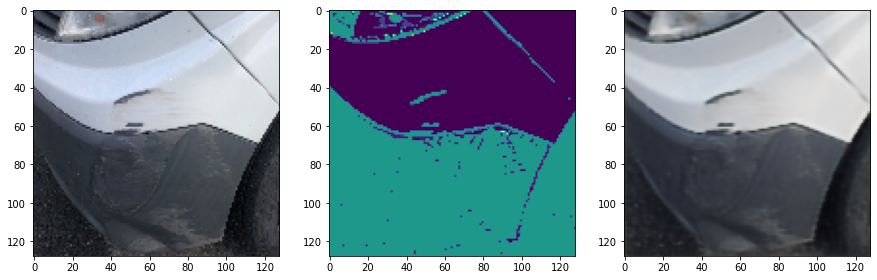

In [591]:
seg=visualise_seg(dam_gen.__getitem__(np.random.randint(1,100))[0],wn.encoder)


[ 1  2  4  8  9 15 16 17]


<tf.Tensor: shape=(1, 128, 128), dtype=int64, numpy=
array([[[ 9,  9,  9, ...,  1,  1,  1],
        [ 9,  9,  9, ...,  1,  1,  1],
        [ 9,  9,  9, ...,  1, 17,  1],
        ...,
        [ 9,  9,  9, ...,  1,  1,  1],
        [ 1,  2,  9, ...,  1,  9,  9],
        [ 1,  1,  9, ...,  9,  9,  9]]])>

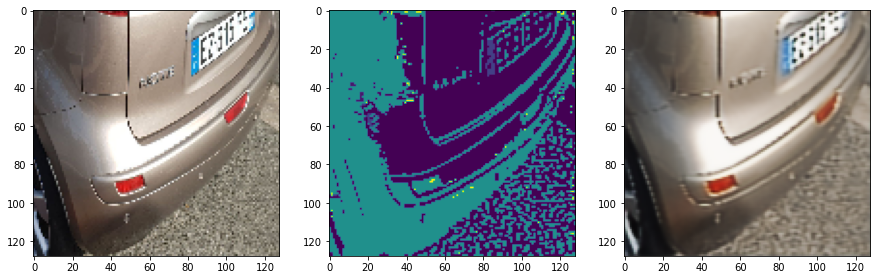

In [630]:
visualise_seg(non_dam_gen.__getitem__(11)[0],wn.encoder)


[ 1  2  4  8  9 15 16 17]


<tf.Tensor: shape=(1, 128, 128), dtype=int64, numpy=
array([[[ 9,  1,  1, ...,  9,  9,  9],
        [ 9,  1,  1, ...,  9,  9,  9],
        [ 9,  1, 17, ...,  9,  9,  9],
        ...,
        [ 1,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ...,  9,  9,  9]]])>

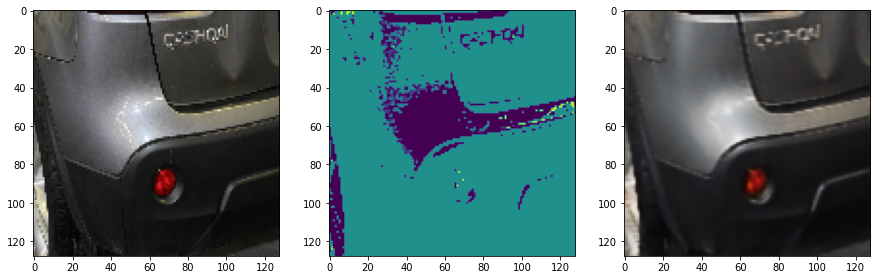

In [629]:
visualise_seg(dam_gen.__getitem__(3)[0],wn.encoder)

In [625]:
dams_reco = []
ndams_reco = []

dams_seg = []
ndams_seg = []

dic_dam = {}
dic_non_dam = {}


for i in range(18):
    dic_dam[i]=0
    dic_non_dam[i]=0

for i in range(0,80):
    
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_ndam = wn.encoder(ndam)
    
    ag_dam = tf.math.argmax(seg_dam, axis=-1, output_type=tf.dtypes.int64)
    ag_dam_unique = np.unique(np.array(ag_dam))
    for j in ag_dam_unique:
        dic_dam[j]+=1
    
    ag_n_dam = tf.math.argmax(seg_ndam, axis=-1, output_type=tf.dtypes.int64)
    ag_n_dam_unique = np.unique(np.array(ag_n_dam))
    for j in ag_n_dam_unique:
        dic_non_dam[j]+=1
  
    

<AxesSubplot:>

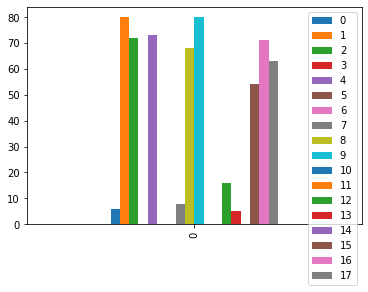

In [626]:
dic_dam
df = pd.DataFrame(data=dic_dam,index=[0])
df.plot.bar()

<AxesSubplot:>

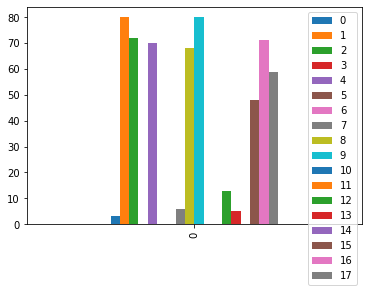

In [627]:
dic_dam
df = pd.DataFrame(data=dic_non_dam,index=[0])
df.plot.bar()

# TEST

In [409]:
losses_1=[]
losses_2=[]
image = non_dam_gen.__getitem__(np.random.randint(1,100))
image = tf.convert_to_tensor(image)
for i in range(10):
    
    seg = encoder(image)
    loss = ncut_loss.compute_soft_ncuts(image,seg,neighbor_filter)
    loss_r = tf.keras.losses.MeanSquaredError()(image,wn(image))
    losses_1.append(loss.numpy())
    losses_2.append(loss_r.numpy())

In [404]:
print(np.var(np.array(losses_1)))
print(np.var(np.array(losses_2)))

3.8296594e-06
1.0922101e-09


In [410]:
print(np.var(np.array(losses_1)))
print(np.var(np.array(losses_2)))

1.4992054e-05
1.2845428e-08


In [438]:
print(np.var(np.array(losses_1)))
print(np.var(np.array(losses_2)))

1.4992054e-05
1.2845428e-08


In [440]:
dams_reco = []
ndams_reco = []

dams_seg = []
ndams_seg = []


for i in range(0,50):
    
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_ndam = wn.encoder(ndam)
    
    seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg.append(seg_loss_dam.numpy())
    ndams_seg.append(seg_loss_ndam.numpy())
    
    dams_reco.append(tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
    ndams_reco.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())
    

<AxesSubplot:>

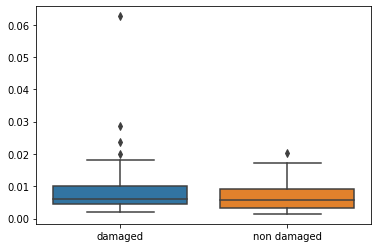

In [484]:
data = {'damaged':dams_reco,'non damaged':ndams_reco}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

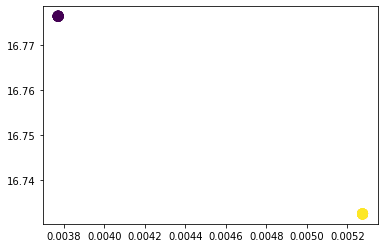

In [437]:
x_plot = ndams_reco+dams_reco
y_plot = dams_seg+ndams_seg
label = [0]*50+[1]*50
plt.scatter(x_plot, y_plot, s=100, c=label,alpha=0.2)

In [470]:
losses_r_dam_vars  = []
losses_s_dam_vars  = []
losses_r_dam_means = []
losses_s_dam_means = []

losses_r_ndam_vars = []
losses_s_ndam_vars = []
losses_r_ndam_means = []
losses_s_ndam_means = []

for i in range(0,50):
    
    print(i)
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    
    losses_r_dam=[]
    losses_s_dam=[]
    for i in range(10):
        
        seg = encoder(dam)
        loss = ncut_loss.compute_soft_ncuts(dam,seg,neighbor_filter)
        loss_r = tf.keras.losses.MeanSquaredError()(dam,wn(dam))
        losses_r_dam.append(loss.numpy())
        losses_s_dam.append(loss_r.numpy())
    
    losses_r_dam_var = np.var(np.array(losses_r_dam))
    losses_s_dam_var = np.var(np.array(losses_s_dam))
    losses_r_dam_mean = np.var(np.array(losses_r_dam))
    losses_s_dam_mean = np.var(np.array(losses_s_dam))
    
    losses_r_dam_vars.append(losses_r_dam_var)
    losses_s_dam_vars.append(losses_s_dam_var)
    losses_r_dam_means.append(losses_r_dam_mean)
    losses_s_dam_means.append(losses_s_dam_mean)
    
    
    
    losses_r_ndam=[]
    losses_s_ndam=[]
    for i in range(10):
        
        seg = encoder(ndam)
        loss = ncut_loss.compute_soft_ncuts(ndam,seg,neighbor_filter)
        loss_r = tf.keras.losses.MeanSquaredError()(ndam,wn(ndam))
        losses_r_ndam.append(loss.numpy())
        losses_s_ndam.append(loss_r.numpy())
        
    losses_r_ndam_var = np.var(np.array(losses_r_ndam))
    losses_s_ndam_var = np.var(np.array(losses_s_ndam))
    losses_r_ndam_mean = np.var(np.array(losses_r_ndam))
    losses_s_ndam_mean = np.var(np.array(losses_s_ndam))
    
    losses_r_ndam_vars.append(losses_r_ndam_var)
    losses_s_ndam_vars.append(losses_s_ndam_var)
    losses_r_ndam_means.append(losses_r_ndam_mean)
    losses_s_ndam_means.append(losses_s_ndam_mean)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [472]:
losses_r_dam_vars[i]

2.9744156e-06

In [475]:
X_clf=[]

for i in range(len(ndams_reco)):
    X_clf.append([
        losses_r_dam_vars[i],
        losses_s_dam_vars[i],
        losses_r_dam_means[i],
        losses_s_dam_means[i],
    ])
    
for i in range(len(dams_reco)):
    X_clf.append([
        losses_r_ndam_vars[i],
        losses_s_ndam_vars[i],
        losses_r_ndam_means[i],
        losses_s_ndam_means[i],
    ])

X_clf = np.array(X_clf)
print(X_clf.shape)



y_clf = [0]*50+[1]*50
clf = LogisticRegression()
clf.fit(np.array(X_clf),np.array(y_clf).reshape(-1, 1))

print(clf.score(X_clf,y_clf))


(100, 4)
0.5


In [481]:
d = pd.DataFrame(data={'dam_reco':losses_s_dam_means,'ndam_reco':losses_s_ndam_means})

<AxesSubplot:>

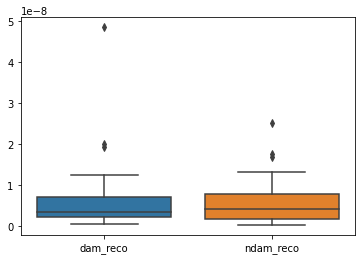

In [482]:
sns.boxplot(data=d)

In [460]:
dm = pd.DataFrame(data={'dam':losses_s_dam_means,'ndam':losses_s_ndam_means})

<AxesSubplot:>

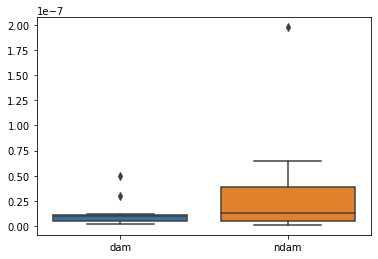

In [461]:
sns.boxplot(data=dm)

In [315]:
X_clf=[]

for i in range(len(ndams_reco)):
    X_clf.append([ndams_reco[i],ndams_seg[i]])
for i in range(len(dams_reco)):
    X_clf.append([dams_reco[i],dams_seg[i]])

X_clf = np.array(X_clf)
print(X_clf.shape)



y_clf = [0]*50+[1]*50
clf = LogisticRegression()
clf.fit(np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))

print(clf.score(X_clf,y_clf))


(100, 2)
0.5


In [115]:
dams_reco_test = []
ndams_reco_test = []

dams_seg_test = []
ndams_seg_test = []

for i in range(500,550):
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_ndam = wn.encoder(ndam)
    
    seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg_test.append(seg_loss_dam.numpy())
    ndams_seg_test.append(seg_loss_ndam.numpy())
    
    dams_reco_test.append(tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
    ndams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())
    

KeyboardInterrupt: 

In [ ]:
X_test=[]

for i in range(len(ndams_reco_test)):
    X_test.append([ndams_reco_test[i],ndams_seg_test[i]])
for i in range(len(dams_reco_test)):
    X_test.append([dams_reco_test[i],dams_seg_test[i]])

X_test = np.array(X_test)
print(X_test.shape)

In [ ]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*50+[1]*50

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


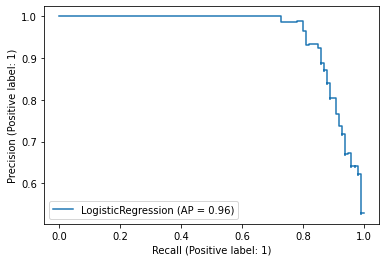

In [98]:


disp = plot_precision_recall_curve(clf,np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


In [ ]:
disp = plot_precision_recall_curve(clf,np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))

In [ ]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*100+[1]*100

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


In [ ]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


In [ ]:
dam = dam_gen.__getitem__(np.random.randint(50,100))
#print(ndam.shape)
plt.figure(figsize=(5,5))
plt.imshow(dam[0])

dam=tf.convert_to_tensor(dam)  
#seg_dam = wn.encoder(dam)
seg_dam = wn.encoder(dam)

#seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)


seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
loss_reco = (tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
print(seg_loss_dam,loss_reco)


clf.predict(np.array([loss_reco,seg_loss_dam]).reshape(1, -1))

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
len(non_dam_gen)

In [ ]:
len(dam_gen)

# TEST

In [167]:
def test(k=40,ckpt=100):
    
    print("CKpt ", ckpt)
    path ="/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/Wnet18/ckpt"+str(ckpt)
    wn.load_weights(path)
    
    dams_reco = []
    ndams_reco = []

    dams_seg = []
    ndams_seg = []

    for i in range(0,k):
        ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))

        dam = tf.convert_to_tensor(dam_gen.__getitem__(i))

        seg_dam = wn.encoder(dam)
        seg_ndam = wn.encoder(ndam)

        seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
        seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)

        dams_seg.append(seg_loss_dam.numpy())
        ndams_seg.append(seg_loss_ndam.numpy())

        dams_reco.append(tf.keras.losses.MeanSquaredError()(ndam,wn(dam)).numpy())
        ndams_reco.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())
        
        
    data = {'damaged':dams_reco,'non damaged':ndams_reco}
    df = pd.DataFrame(data=data)
    
    #plt.figure()
    #sns.boxplot(data=df)
    
    x_plot = ndams_reco+dams_reco
    y_plot = dams_seg+ndams_seg
    label = [0]*k+[1]*k
    #plt.figure()
    #plt.scatter(x_plot, y_plot, s=200, c=label,alpha=0.2)
    
    
    X_clf=[]
    for i in range(len(ndams_reco)):
        X_clf.append([ndams_reco[i],ndams_seg[i]])
    for i in range(len(dams_reco)):
        X_clf.append([dams_reco[i],dams_seg[i]])
    X_clf = np.array(X_clf)

    y_clf = [0]*k+[1]*k
    clf = LogisticRegression()
    clf.fit(np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))
    
    train_score = clf.score(X_clf,y_clf)
    print('Trraining score ',train_score)

    ## TEST
    
    dams_reco_test = []
    ndams_reco_test = []

    dams_seg_test = []
    ndams_seg_test = []

    for i in range(k,2*k):
        ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))

        dam = tf.convert_to_tensor(dam_gen.__getitem__(i))

        seg_dam = wn.encoder(dam)
        seg_ndam = wn.encoder(ndam)

        seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
        seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)

        dams_seg_test.append(seg_loss_dam.numpy())
        ndams_seg_test.append(seg_loss_ndam.numpy())

        dams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(dam)).numpy())
        ndams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())

    
    X_test=[]
    for i in range(len(ndams_reco_test)):
        X_test.append([ndams_reco_test[i],ndams_seg_test[i]])
    for i in range(len(dams_reco_test)):
        X_test.append([dams_reco_test[i],dams_seg_test[i]])

    X_test = np.array(X_test)
    
    
    
       
    y_test = [0]*k+[1]*k

    pred = clf.predict(np.array(X_test).reshape(-1,2))

    clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))
    
    
    #plt.figure()
    #disp = plot_precision_recall_curve(clf,np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))

    test_score = clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))
    
    print("Test scores ",test_score )

    #print(classification_report(y_test, pred))
    
    return(train_score,test_score)

In [ ]:
test(k=500,ckpt=500)

CKpt  500
Trraining score  0.947


In [151]:
k=100
data = {}
ckpts=[200,400,500,600,1000,1500,2000,2200]
for ckpt in ckpts:
    train_score,test_score = test(k,ckpt)
    data[ckpt]={"train_score":train_score,"test_score":test_score}
    print(data)

CKpt  200
Trraining score  0.675
Test scores  0.665
{200: {'train_score': 0.675, 'test_score': 0.665}}
CKpt  400
Trraining score  0.76
Test scores  0.715
{200: {'train_score': 0.675, 'test_score': 0.665}, 400: {'train_score': 0.76, 'test_score': 0.715}}
CKpt  500
Trraining score  0.915
Test scores  0.94
{200: {'train_score': 0.675, 'test_score': 0.665}, 400: {'train_score': 0.76, 'test_score': 0.715}, 500: {'train_score': 0.915, 'test_score': 0.94}}
CKpt  600
Trraining score  0.825
Test scores  0.83
{200: {'train_score': 0.675, 'test_score': 0.665}, 400: {'train_score': 0.76, 'test_score': 0.715}, 500: {'train_score': 0.915, 'test_score': 0.94}, 600: {'train_score': 0.825, 'test_score': 0.83}}
CKpt  1000
Trraining score  0.86
Test scores  0.85
{200: {'train_score': 0.675, 'test_score': 0.665}, 400: {'train_score': 0.76, 'test_score': 0.715}, 500: {'train_score': 0.915, 'test_score': 0.94}, 600: {'train_score': 0.825, 'test_score': 0.83}, 1000: {'train_score': 0.86, 'test_score': 0.85}}

In [153]:
df = pd.DataFrame(data=data)
df

,200,400,500,600,1000,1500,2000,2200
train_score,0.675,0.760,0.915,0.825,0.86,0.89,0.885,0.900
test_score,0.665,0.715,0.940,0.830,0.85,0.89,0.900,0.905


In [157]:
k=100
data = {}
ckpts=[200,400,500,600,800,1000,1500,1700]
for ckpt in ckpts:
    train_score,test_score = test(k,ckpt)
    data[ckpt]={"train_score":train_score,"test_score":test_score}
    print(data)

CKpt  200
Trraining score  0.925
Test scores  0.92
{200: {'train_score': 0.925, 'test_score': 0.92}}
CKpt  400
Trraining score  0.925
Test scores  0.935
{200: {'train_score': 0.925, 'test_score': 0.92}, 400: {'train_score': 0.925, 'test_score': 0.935}}
CKpt  500
Trraining score  0.605
Test scores  0.56
{200: {'train_score': 0.925, 'test_score': 0.92}, 400: {'train_score': 0.925, 'test_score': 0.935}, 500: {'train_score': 0.605, 'test_score': 0.56}}
CKpt  600
Trraining score  0.695
Test scores  0.65
{200: {'train_score': 0.925, 'test_score': 0.92}, 400: {'train_score': 0.925, 'test_score': 0.935}, 500: {'train_score': 0.605, 'test_score': 0.56}, 600: {'train_score': 0.695, 'test_score': 0.65}}
CKpt  800
Trraining score  0.92
Test scores  0.92
{200: {'train_score': 0.925, 'test_score': 0.92}, 400: {'train_score': 0.925, 'test_score': 0.935}, 500: {'train_score': 0.605, 'test_score': 0.56}, 600: {'train_score': 0.695, 'test_score': 0.65}, 800: {'train_score': 0.92, 'test_score': 0.92}}
CK

In [158]:
df = pd.DataFrame(data=data)
df

,200,400,500,600,800,1000,1500,1700
train_score,0.925,0.925,0.605,0.695,0.92,0.92,0.825,0.69
test_score,0.920,0.935,0.560,0.650,0.92,0.91,0.790,0.64
